In [ ]:
"""Unet to detect small objects such as landmines in aerial images by Image Segmentation. 

"""
"""
Application of Deep learning for Image Segmentation of landmines in aerial images
"""
"""
Train an Unet model on VisDrone2019 dataset on Tensorflow Framework using Using Keras Functional API
Test the trained model to detect landmines in
LANDMINE THERMAL IMAGE SERIES Dataset
https://ieee-dataport.org/open-access/landmine-thermal-image-series files

Datasets used are downloaded in the local storage
"""

In [1]:
import os
import io
import sys
import scipy.io
import scipy.misc
import itertools

#from glob2 import glob
from six import BytesIO
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.layers import MaxPooling2D,LSTM, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



import csv


import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


import pathlib

import PIL
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps


import traceback
import numpy.random as npr
from tensorflow.keras.layers import *


#from keras import backend as K


In [2]:
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)





TensorFlow version: 2.9.0


In [4]:
tf.compat.v1.keras.layers.enable_v2_dtype_behavior()

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()


print("Num GPUs Available: ", len(tf.config.list_physical_devices('cpu')))
print(" Physical devices:" , tf.config.list_physical_devices('cpu'))
#print("is_apple_mlc_enabled %s" % mlcompute.is_apple_mlc_enabled())
#print("is_tf_compiled_with_apple_mlc %s" % mlcompute.is_tf_compiled_with_apple_mlc())
print(f"eagerly? {tf.executing_eagerly()}")

print(tf.config.list_logical_devices())





Num GPUs Available:  0
 Physical devices: []
eagerly? True
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [5]:
#from keras.models import Input, Model
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from IPython.display import Image, display
print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.9.0


In [ ]:
"""
Problem: Detecting objects,mines in aerial images
"""

In [ ]:

"""
https://github.com/VisDrone/VisDrone-Dataset
Citation:
@ARTICLE{9573394,
  author={Zhu, Pengfei and Wen, Longyin and Du, Dawei and Bian, Xiao and Fan, Heng and Hu, Qinghua and Ling, Haibin},
  journal={IEEE Transactions on Pattern Analysis and Machine Intelligence}, 
  title={Detection and Tracking Meet Drones Challenge}, 
  year={2021},
  volume={},
  number={},
  pages={1-1},
  doi={10.1109/TPAMI.2021.3119563}}
"""
"""
VisDromes2019 is a large-scale benchmark dataset with carefully annotated ground-truth for various important 
computer vision tasks, named VisDrone, to make vision meet drones. The VisDrone2019 dataset is collected by 
the AISKYEYE team at Lab of Machine Learning and Data Mining , Tianjin University, China. 
The benchmark dataset consists of 288 video clips formed by 261,908 frames and 10,209 static images,
captured by various drone-mounted cameras, covering a wide range of aspects including location(taken from 14 different cities separated by thousands of kilometers in China), 
environment (urban and country), 
objects (pedestrian, vehicles, bicycles, etc.), and 
density (sparse and crowded scenes).
Note that, the dataset was collected using various drone platforms (i.e., drones with different models),
in different scenarios, and under various weather and lighting conditions. 
These frames are manually annotated with more than 2.6 million bounding boxes of targets of frequent interests,
such as pedestrians, cars, bicycles, and tricycles. Some important attributes including scene visibility,
object class and occlusion, are also provided for better data utilization.
"""
#https://github.com/VisDrone/VisDrone2018-DET-toolkit
#Annotation file format
 #<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>


   # Name                                                  Description
#-------------------------------------------------------------------------------------------------------------------------------     
 #<bbox_left>	     The x coordinate of the top-left corner of the predicted bounding box

 #<bbox_top>	     The y coordinate of the top-left corner of the predicted object bounding box

 #<bbox_width>	     The width in pixels of the predicted object bounding box

#<bbox_height>	     The height in pixels of the predicted object bounding box

#   <score>	     The score in the DETECTION file indicates the confidence of the predicted bounding box enclosing 
                    # an object instance.
                    # The score in GROUNDTRUTH file is set to 1 or 0. 1 indicates the bounding box is considered in evaluation, 
                    # while 0 indicates the bounding box will be ignored.
                      
#<object_category>    The object category indicates the type of annotated object, (i.e., ignored regions(0), pedestrian(1), 
                     #people(2), bicycle(3), car(4), van(5), truck(6), tricycle(7), awning-tricycle(8), bus(9), motor(10), 
                     #others(11))
                      
#<truncation>	     The score in the DETECTION result file should be set to the constant -1.
                    # The score in the GROUNDTRUTH file indicates the degree of object parts appears outside a frame 
                     #(i.e., no truncation = 0 (truncation ratio 0%), and partial truncation = 1 (truncation ratio 1% ~ 50%)).
                      
#<occlusion>	     The score in the DETECTION file should be set to the constant -1.
                    # The score in the GROUNDTRUTH file indicates the fraction of objects being occluded (i.e., no occlusion = 0 
                     #(occlusion ratio 0%), partial occlusion = 1 (occlusion ratio 1% ~ 50%), and heavy occlusion = 2 
                     #(occlusion ratio 50% ~ 100%)).



In [7]:
#Explore an image from the dataset
# summarize some details about the image

relative_path_image='VisDrone2019-DET-train/images/0000002_00005_d_0000014.jpg'
# load the image and convert into
# numpy array
# Get the absolute path by joining the current working directory and the relative path
abs_path_image = os.path.join(os.getcwd(), relative_path_image)
img = PIL.Image.open(abs_path_image)
  
# asarray() class is used to convert
# PIL images into NumPy arrays
np_imagetest = np.array(img)
  
# <class 'numpy.ndarray'>
print(type(np_imagetest))
W,H,D= (np_imagetest).shape 
#  shape
print((np_imagetest).shape)



<class 'numpy.ndarray'>
(540, 960, 3)


In [8]:
# extract image id
path_img=abs_path_image
image_id = path_img.split('/')[-4:]
path_mask= image_id[0]+'/'+image_id[1]+'/masks/'+image_id[3]
print(path_mask)
print(image_id[0])

ObjectDetection/VisDrone2019-DET-train/masks/0000002_00005_d_0000014.jpg
ObjectDetection


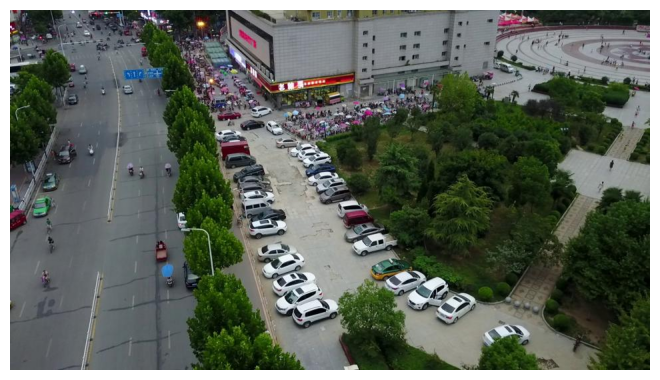

In [9]:
#Visualizing the images
# Create figure and axes
fig = plt.figure(frameon=False)
  
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Display the image
ax.imshow(np_imagetest)



In [ ]:
#Define function to create masks for images from corresponding annotation files in VisDrone2019 dataset

def create_mask(image_filepath,anno_filepath): 
    
    path_b=anno_filepath
    path_img=image_filepath

     # extract image id
    image_id = path_img.split('/')[-4:]
    path_mask=image_id[0]+'/'+image_id[1]+'/masks/'+image_id[3]
    data_df = pd.read_csv(path_b, delimiter = ',',header=None)
    
    #<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
    #(x1,y1,w1,h1,sc,cat,tr,oc)= line
     
    data_df.columns=['x1','y1','w1','h1','sc','cat','tr','oc']    
    #print(data_df.info())
    listdf=data_df[['x1','y1','w1','h1']].values.tolist()
    #image_id = path_img.split('/')[-1]
    
    img = PIL.Image.open(path_img)
  
    # asarray() class is used to convert
    # PIL images into NumPy arrays
    np_image = np.array(img)

    # <class 'numpy.ndarray'>
    
    W,H,D= (np_image).shape 
    x = np.zeros(np_image.shape[:-1])+3
    fig, ax = plt.subplots(1)
    for i in range(len(listdf)): 
        [x1,y1,w1,h1]=listdf[i]
        bbox_list=[x1,y1,w1,h1]
    
        bbox=bbox_list
        #print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1,
                         edgecolor='r', facecolor="g")
 
        ax.add_patch(rect)
        plt.axis('off')
    
        ax.imshow(x)
    # Create figure and axes
    
    buff=io.BytesIO()
    fig.savefig(buff, format='jpg', dpi='figure')
    buff.seek(0)
    
    img_mask = np.frombuffer(buff.getvalue(), dtype= 'uint8',count= -1, offset=0)
    
    fig.savefig(path_mask, bbox_inches='tight', pad_inches=0)   
    buff.close()
    plt.close(fig) 
    
    mask_arr = PIL.Image.open(path_mask)
    arr = np.array(mask_arr)
    mask_bool=np.where(arr>0,1,0)
    mask=np.ma.MaskedArray(arr,mask_bool)
    im = PIL.Image.fromarray(mask)
    im.save(path_mask)
    mask_arr.close()
    im.close()
    

In [11]:
 
train_dataset_dir = 'VisDrone2019-DET-train' 
test_dataset_dir = 'VisDrone2019-DET-test-dev'
val_dataset_dir = 'VisDrone2019-DET-val'
# define data locations for images and annotations
train_images_dir = train_dataset_dir + '/images/'
train_annotations_dir = train_dataset_dir + '/annotations/'
train_masks_dir = train_dataset_dir + '/masks/'


test_images_dir = test_dataset_dir + '/images/'
test_annotations_dir = test_dataset_dir + '/annotations/'
test_masks_dir = test_dataset_dir + '/masks/'

val_images_dir = val_dataset_dir + '/images/'
val_annotations_dir = val_dataset_dir + '/annotations/'
val_masks_dir = val_dataset_dir + '/masks/'
      


In [14]:

def process_dataset(dataset_dir):
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        masks_dir = dataset_dir + '/masks/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        imgId =[]
        imgPath = []
        maskPath = []
        bboxPath = []
        #for i in range(num_images):
        img_fileslist=list(sorted(os.listdir(images_dir)))
        annotations_fileslist=list(sorted(os.listdir(annotations_dir)))
        for filename in img_fileslist:   
               
               # setting image file
               path_img = images_dir + filename
               path_mask = masks_dir + filename
               # adding images and annotations to dataset
               #self.add_image('dataset', image_id=image_id, path=path_img, annotation= path_bb)
               imgPath.append(path_img)
               maskPath.append(path_mask) 
        for filename in annotations_fileslist:
               # extract image id
               #image_id =  filename[-4:]
                # setting annotations file
               path_bb =  annotations_dir + filename
               bboxPath.append(path_bb)
               #imgId.append(image_id)
           
        return imgPath,bboxPath,maskPath

In [15]:
train_files,trainAnno_files,train_masks = process_dataset(train_dataset_dir)
test_files,testAnno_files,test_masks = process_dataset(test_dataset_dir)
val_files,valAnno_files,val_masks = process_dataset(val_dataset_dir)

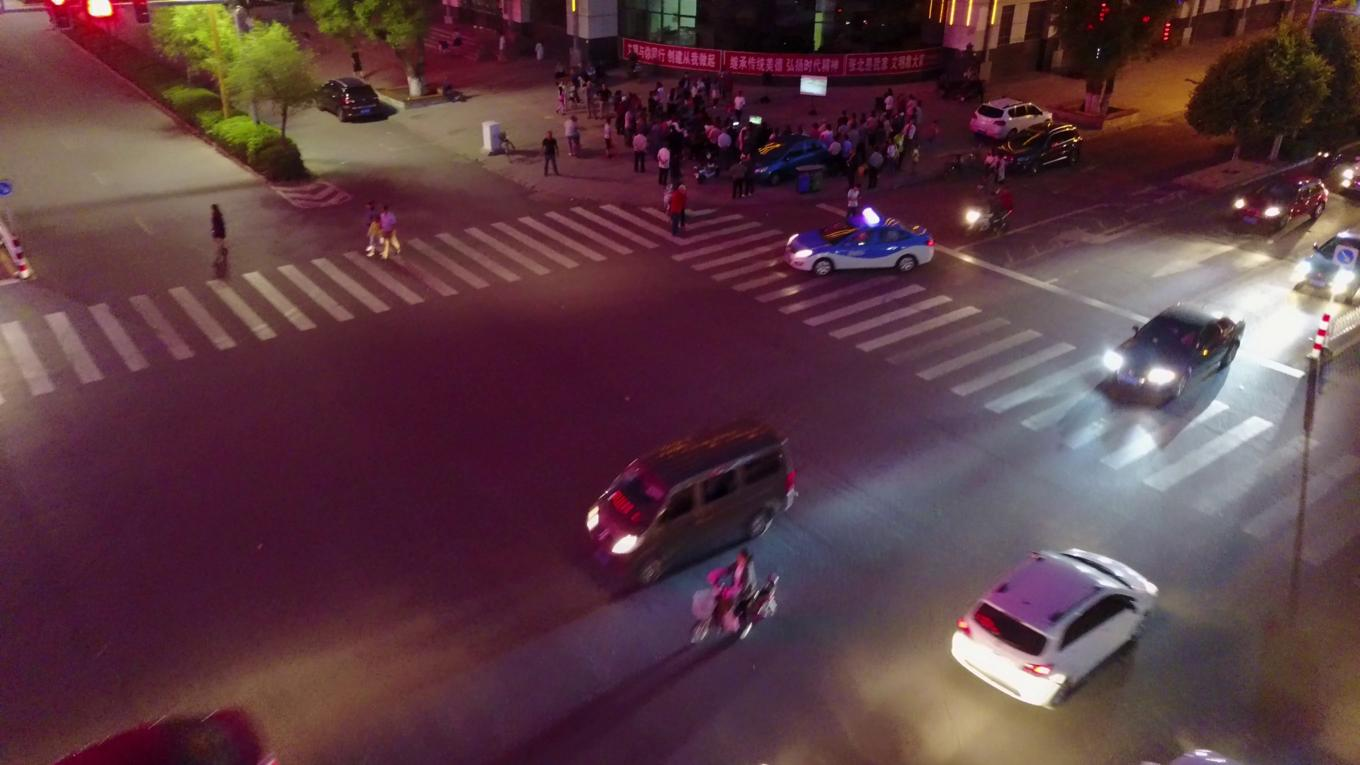

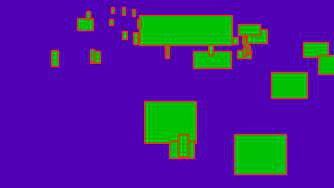

(188, 334, 3)

In [16]:
# Display input image 
display(Image(filename=train_files[77]))
img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.load_img(train_masks[77]))
(train_masks[77])
display(img)
np.shape(img)

In [ ]:
#Creating masks in the local storage 
#Do not run this cell if the required data is already present
for img_file,anno_file in list(zip(train_files[2490:2551],trainAnno_files[2490:2551])):
     create_mask(img_file,anno_file)

In [ ]:
#Creating masks in the local storage 
#Do not run this cell if the required data is already present
for img_file,anno_file in list(zip(test_files[1090:1151],testAnno_files[1090:1151])):
    create_mask(img_file,anno_file)

In [ ]:
#Creating masks in the local storage 
#Do not run this cell if the required data is already present
for img_file,anno_file in list(zip(val_files[548:591],valAnno_files[548:591])):
    create_mask(img_file,anno_file)

In [31]:
#Functions to load images & masks to model input
#DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
#It is PIL.Image.Resampling.LANCZOS but not PIL.Image.LANZCOS, this is a relatively new feature, so changing it may break the tool for older Pillow versions.
def loadimage(x):
    img = PIL.Image.open(x)
    input_image = img.resize((160,160),PIL.Image.Resampling.LANCZOS)
    input_image=np.asarray(input_image)
    return np.absolute(input_image-0.5)/255
def loadmask(y):
    img = PIL.Image.open(y)
    input_mask= img.resize((160,160),PIL.Image.Resampling.LANCZOS)
    input_mask=np.asarray(input_mask)
    input_mask=np.absolute(input_mask-0.5)/255
    input_mask=np.where((input_mask>=0.00196078) & (input_mask<=0.26470588),0,input_mask)
    input_mask=np.where((input_mask>=0.26470588) & (input_mask<=0.32352941),0,input_mask)
    input_mask=np.where((input_mask>=0.32352941) & (input_mask<=0.35176471),0,input_mask)
    input_mask=np.where(input_mask!=0,1,input_mask)
    return input_mask

/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/2975550147.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image = img.resize((160,160),PIL.Image.ANTIALIAS)
/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/2975550147.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_mask= img.resize((160,160),PIL.Image.ANTIALIAS)


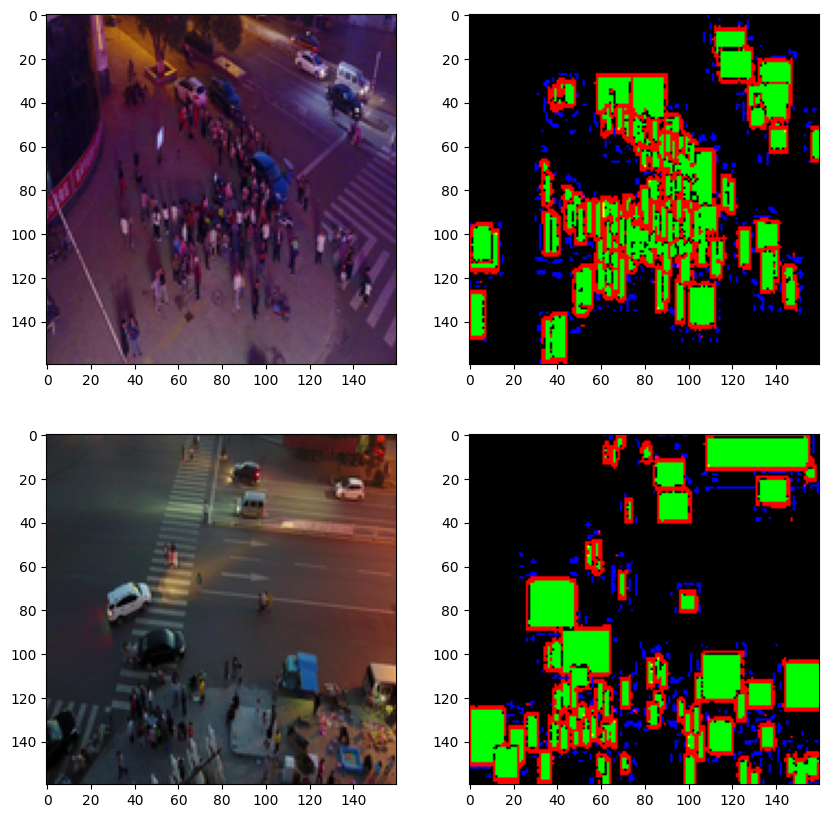

In [19]:
#Check loadimage funtion to load image to model input
sample_image1=loadimage(train_files[80])
sample_mask1=loadmask(train_masks[80])
sample_image2=loadimage(train_files[90])
sample_mask2=loadmask(train_masks[90])
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2,2,1)
plt.imshow(sample_image1)
fig.add_subplot(2,2,2)
plt.imshow(sample_mask1)
fig.add_subplot(2,2,3)
plt.imshow(sample_image2)
fig.add_subplot(2,2,4)
plt.imshow(sample_mask2)

(array([[116.,   0.,   0., ...,   0.,   0.,  44.],
        [145.,   0.,   0., ...,   0.,   0.,  15.],
        [150.,   0.,   0., ...,   0.,   0.,  10.],
        ...,
        [155.,   0.,   0., ...,   0.,   0.,   5.],
        [156.,   0.,   0., ...,   0.,   0.,   4.],
        [156.,   0.,   0., ...,   0.,   0.,   4.]]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 160 BarContainer objects>)

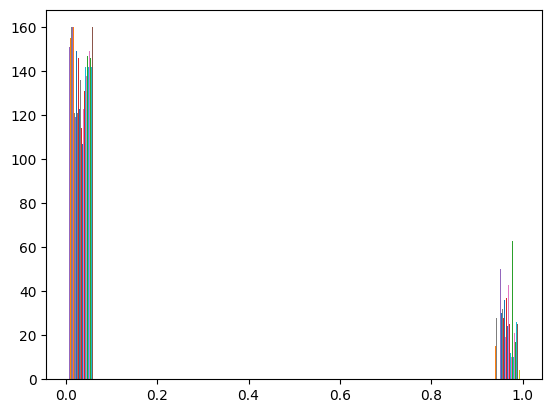

In [20]:
#plot histogram to view
plt.hist(sample_mask1[:,:,0],bins=15)


In [21]:
class DroneImages(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path_img in enumerate(batch_input_img_paths):
            img = loadimage(path_img)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for j, path_mask in enumerate(batch_target_img_paths):
            img = loadmask(path_mask)
            #y[j] = np.expand_dims(img, 2)
            y[j] = img
            # Ground truth labels are  0, 1:
            
        return x, y

In [22]:
train_dataset_images = train_files[0:2550]
train_dataset_masks = train_masks[0:2550]


In [23]:
test_dataset_images = val_files[0:548]
test_dataset_masks = val_masks[0:548]



In [24]:
val_dataset_images = test_files[0:1150]
val_dataset_masks = test_masks[0:1150]


In [25]:

train_size =len(train_dataset_images)
val_size = len(val_dataset_images)
test_size = len(test_dataset_images)


num_examples = train_size + val_size + test_size
print("num_examples:",num_examples)
train_ratio=train_size/num_examples
test_ratio=test_size/num_examples
val_ratio=val_size/num_examples
print("test-train-val-split:")
print("train_size:",train_size, "test_size:",test_size,"val_size:",val_size )
train_length=train_size
test_length=test_size
val_length=val_size
print(f"train_ratio:{train_ratio:.2f}")
print(f"test_ratio:{test_ratio:.2f}")
print(f"val_ratio:{val_ratio:.2f}")
batch_size = 5
buffer_size = 10
STEPS_PER_EPOCH = int(train_size // batch_size)
print("Steps per Epoch",STEPS_PER_EPOCH)
EPOCHS = 10

VALIDATION_STEPS = val_size//batch_size
print("Validation Steps:",VALIDATION_STEPS)
VAL_SUBSPLITS = 1

num_examples: 4248
test-train-val-split:
train_size: 2550 test_size: 548 val_size: 1150
train_ratio:0.60
test_ratio:0.13
val_ratio:0.27
Steps per Epoch 510
Validation Steps: 230


In [26]:
img_size =(160,160)
# Instantiate data Sequences for each split
train_gen = DroneImages(batch_size, img_size, train_dataset_images, train_dataset_masks)
val_gen = DroneImages(batch_size, img_size, val_dataset_images, val_dataset_masks)
test_gen= DroneImages(batch_size, img_size, test_dataset_images, test_dataset_masks)

In [27]:


# Define U-Net model architecture
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Downsample path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Upsample path
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(conv9)
  


    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Define input shape
input_shape = (160, 160, 3)

# Create model instance
Unet_model = unet_model(input_shape)

# Define metrics for evaluation
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
]

# Compile the model
Unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)


In [28]:
print(Unet_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Total params: 31,031,875
Trainable params: 31,031,875
Non-trainable params: 0
__________________________________________________________________________________________________
None


In [30]:

model_history=Unet_model.fit(train_gen,
                epochs= 5,
                batch_size=batch_size,
                validation_data=val_gen)




Epoch 1/5


/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/2975550147.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image = img.resize((160,160),PIL.Image.ANTIALIAS)
/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/2975550147.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_mask= img.resize((160,160),PIL.Image.ANTIALIAS)
2023-05-25 16:17:16.834129: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


510/510 [==============================] - 2740s 5s/step - loss: 0.2061 - binary_accuracy: 0.9509 - precision: 0.0646 - recall: 7.3452e-04 - val_loss: 0.1522 - val_binary_accuracy: 0.9646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
510/510 [==============================] - 2604s 5s/step - loss: 0.1761 - binary_accuracy: 0.9512 - precision: 0.2773 - recall: 0.0025 - val_loss: 0.1433 - val_binary_accuracy: 0.9645 - val_precision: 0.1709 - val_recall: 8.5350e-04
Epoch 3/5
510/510 [==============================] - 3361s 7s/step - loss: 0.1716 - binary_accuracy: 0.9514 - precision: 0.4818 - recall: 0.0055 - val_loss: 0.1466 - val_binary_accuracy: 0.9639 - val_precision: 0.1894 - val_recall: 0.0059
Epoch 4/5
510/510 [==============================] - 4994s 10s/step - loss: 0.1688 - binary_accuracy: 0.9514 - precision: 0.4915 - recall: 0.0096 - val_loss: 0.1398 - val_binary_accuracy: 0.9646 - val_precision: 0.1538 - val_recall: 7.9886e-05
Epoch 5/5
510/510 [==============

In [38]:
test_preds = Unet_model.predict(test_gen)


/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/957739232.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image = img.resize((160,160),PIL.Image.ANTIALIAS)
/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/957739232.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_mask= img.resize((160,160),PIL.Image.ANTIALIAS)


109/109 [==============================] - 148s 1s/step


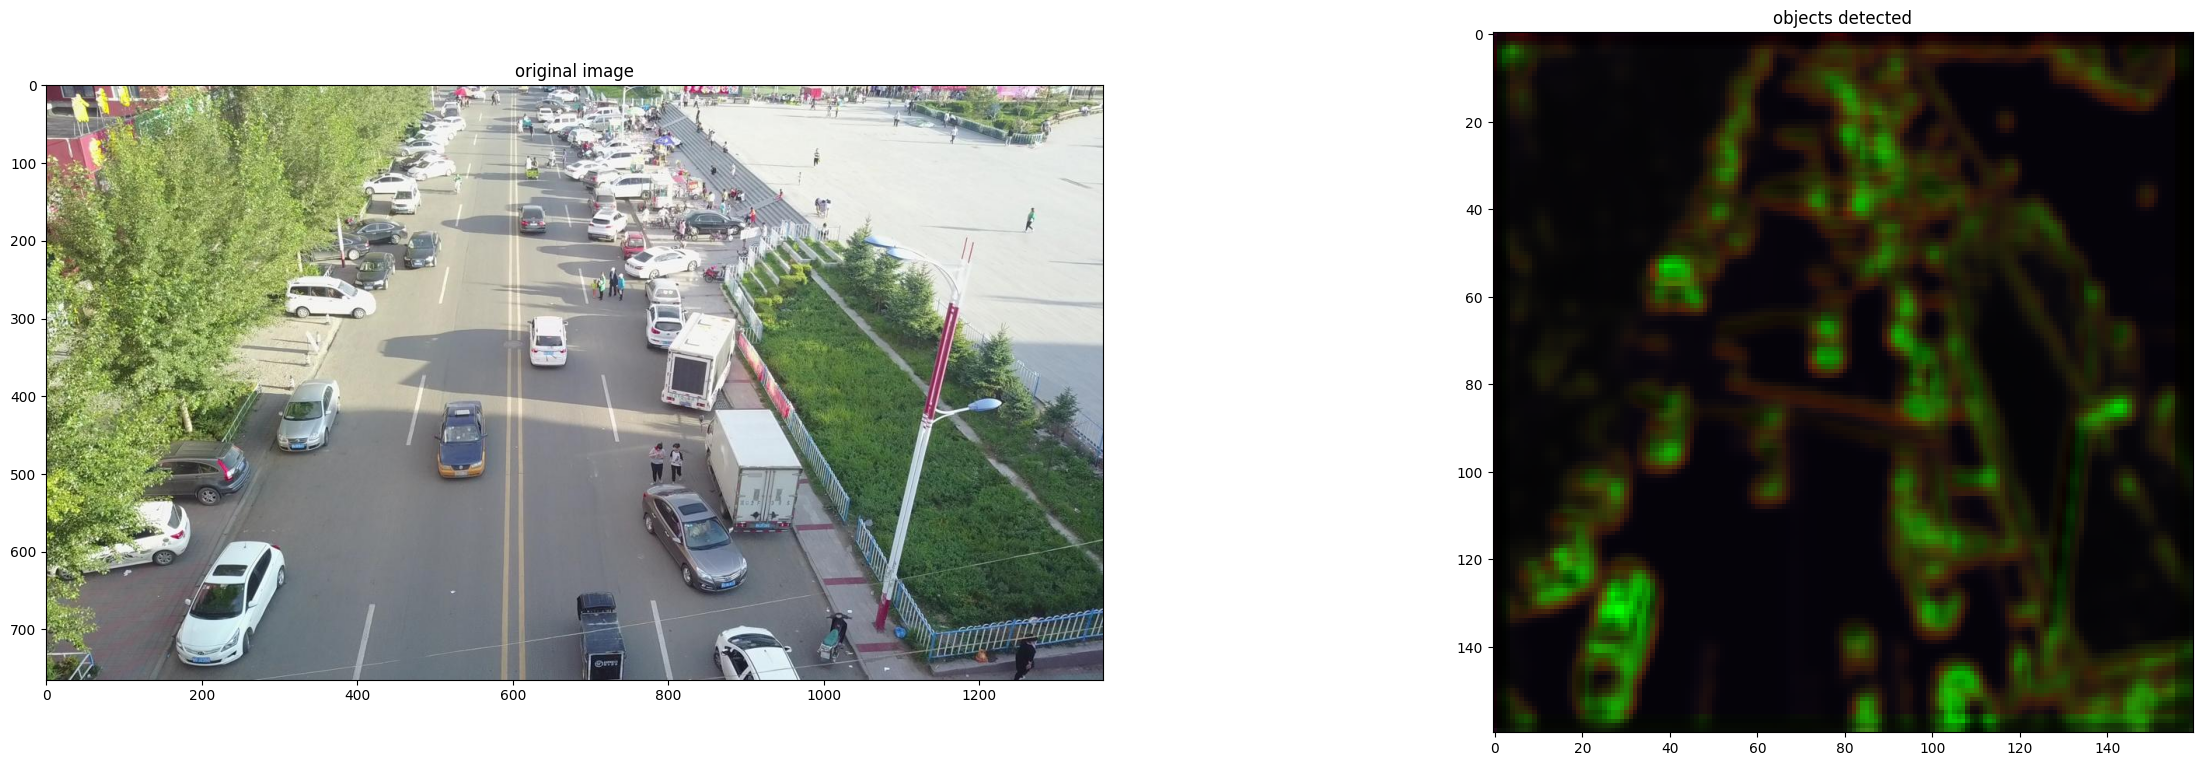

In [61]:
 """display a model's prediction."""
def display_mask(i):
    pred_mask = test_preds[i]
    #pred_mask = np.reshape(pred_mask,(160,160,3))
    #pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = tf.keras.preprocessing.image.array_to_img(pred_mask)
    plt.imshow(pred_mask)
   
   
i=123

# Display input image
img= PIL.Image.open(test_dataset_images[i])
#display(img)
# Display ground-truth target mask
#img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.load_img(test_dataset_masks[i]))
#msk = PIL.Image.open(test_dataset_masks[i])
#display(msk)

# Display mask predicted by our model

#fig,axes = plt.subplots(2,2,figsize =(15,15))
# Display mask predicted by our model
#display_mask(i) 
fig = plt.figure(figsize =(30,20))
fig.tight_layout()
fig.add_subplot(2,2,1).set_title('original image')
plt.imshow(img)
fig.add_subplot(2,2,2).set_title('objects detected')
display_mask(i)


In [44]:
print(model_history.history.keys())
print(model_history.epoch)

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall'])
[0, 1, 2, 3, 4]


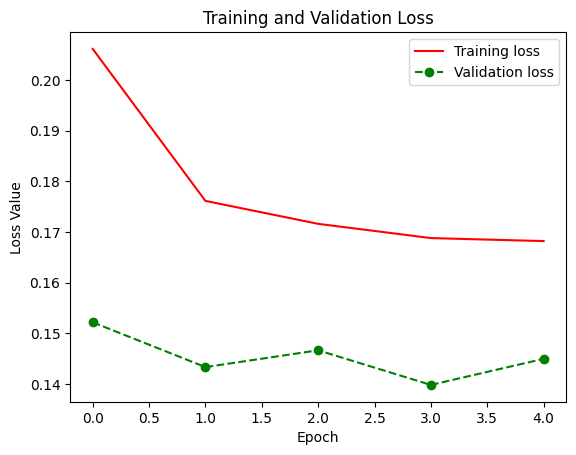

In [35]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['binary_accuracy']
val_accuracy = model_history.history['val_binary_accuracy']
epoch_num = model_history.epoch

plt.plot(epoch_num, loss, 'r', label='Training loss')
plt.plot(epoch_num, val_loss, 'go--', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()

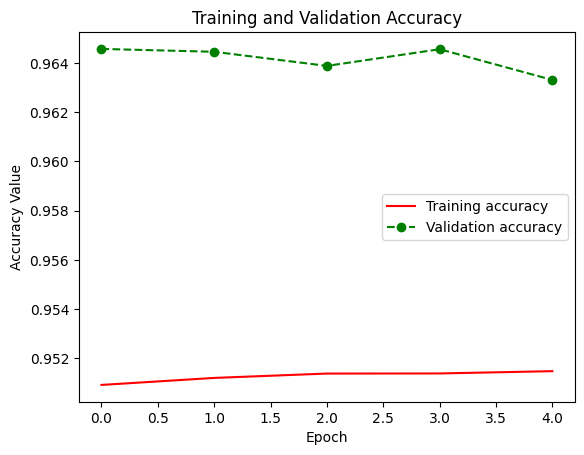

In [36]:
plt.plot(epoch_num, accuracy, 'r', label='Training accuracy')
plt.plot(epoch_num, val_accuracy, 'go--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.title('Training and Validation Accuracy')
plt.legend()

In [37]:
results = Unet_model.evaluate(test_gen, batch_size=batch_size)

/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/957739232.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image = img.resize((160,160),PIL.Image.ANTIALIAS)
/var/folders/y5/383sdlcn58g_zqg_48133p0c0000gn/T/ipykernel_59233/957739232.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_mask= img.resize((160,160),PIL.Image.ANTIALIAS)


109/109 [==============================] - 141s 1s/step - loss: 0.1799 - binary_accuracy: 0.9439 - precision: 0.7049 - recall: 0.0177


In [53]:

print("test loss, test accuracy:", results)

test loss, test accuracy: [0.17987674474716187, 0.9438819885253906, 0.7049384117126465, 0.017659364268183708]


In [81]:

# Create a new folder for saving the model
save_dir = os.path.join(os.getcwd(), 'saved_models')
os.makedirs(save_dir, exist_ok=True)

# Define the path to save the model
model_path = os.path.join(save_dir, 'unet_model.h5')

# Save the pretrained model
Unet_model.save(model_path)


In [107]:
"""Predict the segmentation of Landmines in 
LANDMINE THERMAL IMAGE SERIES Dataset
https://ieee-dataport.org/open-access/landmine-thermal-image-series files"""



test2_dir='testimages'

masks_ds=list((os.listdir('testimages/masks/')))
images_ds=list((os.listdir('testimages/images/')))
imagesdir = 'testimages/images/'
masksdir = 'testimages/masks/'



In [98]:
print(images_ds[1])
# Specify the filename of the image you want to read
image_filename = images_ds[1]  # Replace with the actual image filename

# Join the directory path with the image filename
image_path = os.path.join(imagesdir, image_filename)
print(image_path)

image34.JPEG
testimages/images/image34.JPEG


In [ ]:
#Functions to load images & masks to model input
#DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
#It is PIL.Image.Resampling.LANCZOS but not PIL.Image.LANZCOS, this is a relatively new feature, so changing it may break the tool for older Pillow versions.


In [105]:


def preprocess_and_display(model_path, image_path):
    # Load the trained model
    loaded_model = tf.keras.models.load_model(model_path)

    # Preprocess a single input image
    def preprocess_image(input_image):
        input_image = PIL.Image.open(input_image)
        input_image = input_image.resize((160,160),PIL.Image.Resampling.LANCZOS)
        input_image=np.asarray(input_image)
        preprocessed_image= np.absolute(input_image-0.5)/255 
        return preprocessed_image

    # Load and preprocess a single image for prediction
    preprocessed_image = preprocess_image(image_path)

    # Expand dimensions to match model input shape (batch size of 1)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

    # Make predictions on the preprocessed image
    predictions = loaded_model.predict(preprocessed_image)
    
    # Reshape predictions to remove the batch dimension
    predictions = predictions.squeeze()

    # Display the segmented predicted image
    pred_image=tf.keras.preprocessing.image.array_to_img(predictions)
    plt.axis('off')
    plt.imshow(pred_image)


1/1 [==============================] - 0s 327ms/step


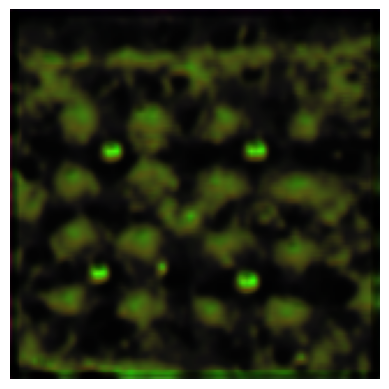

In [106]:
preprocess_and_display(model_path, image_path)
